### CIFAR-100 Image Classification Analysis

**Problem Statement**:

The primary objective of this project is to develop a highly accurate image classification model utilizing the CIFAR-100 dataset. This dataset comprises 60,000 color images, each measuring 32x32 pixels, and is organized into 100 distinct classes. Our aim is to leverage state-of-the-art deep learning techniques to construct and optimize a model that not only achieves superior classification accuracy but also has the capability to classify any images uploaded by users into these defined classes.

By focusing on advanced methodologies in deep learning, we seek to explore various architectures, optimize hyperparameters, and implement effective data preprocessing techniques. This approach will enable us to enhance the model's performance, ensuring it can reliably distinguish between the diverse categories represented in the CIFAR-100 dataset. Ultimately, this project aspires to contribute valuable insights into image classification and provide a robust tool for real-time image analysis.

**Objectives**:

**Build an Accurate Classifier**: Our primary objective is to develop a robust model that can effectively classify images from the CIFAR-100 dataset into one of the 100 specific classes.

**Optimize Model Performance**: We will explore various architectures and fine-tune hyperparameters to enhance the model's accuracy and overall performance.

**Visualize Model Insight**: To better understand the model's performance, we will create visualizations that elucidate how the model makes its predictions and where it may struggle.

**Deploy the Model**: A key aspect of this project is to create a user-friendly interface that allows for real-time image classification, making the model accessible to users.

**Validate Hypotheses**: We will conduct systematic testing of our hypotheses regarding model performance and feature importance, ensuring that our findings are robust.

### Importing necessary libraries

In [1]:
# Data manipulation and analysis
import numpy as np
import pandas as pd

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# TensorFlow and Keras for deep learning
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import cifar100

# Image processing
from PIL import Image

# Additional utilities
import os
import random
import tarfile
import pickle

**Downloading CIFAR-100 Dataset**:
using TensorFlow or PyTorch datasets API for easy access.
For TensorFlow:
Download code commented out after downloading so as not to download again each time I run notebook

In [2]:
# (x_train, y_train), (x_test, y_test) = cifar100.load_data(label_mode='fine')

In [3]:
# (x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar100.load_data()

In [4]:
# # Save the dataset locally in a compressed format
# np.savez_compressed("cifar100_data.npz", x_train=x_train, y_train=y_train, x_test=x_test, y_test=y_test)

In [5]:
# Base directory path
base_path = "3Signet_2"
data_tar_path = os.path.join(base_path, "cifar-100-python.tar.gz")
data_npz_path = os.path.join(base_path, "cifar100_data.npz")
data_extract_path = os.path.join(base_path, "cifar-100-python")

# Check if the data is already saved in .npz format for quicker loading
if os.path.exists(data_npz_path):
    # Load from .npz file if it exists
    data = np.load(data_npz_path)
    x_train, y_train, x_test, y_test = data['x_train'], data['y_train'], data['x_test'], data['y_test']
else:
    # Extract if not already done
    if not os.path.isdir(data_extract_path):
        # Define a simple filter that accepts all files
        def all_files_filter(tarinfo):
            return tarinfo

        with tarfile.open(data_tar_path, "r:gz") as tar:
            tar.extractall(path=base_path, filter=all_files_filter)

    # Function to load data from CIFAR-100 file
    def load_cifar100_batch(file_path):
        with open(file_path, 'rb') as file:
            batch = pickle.load(file, encoding='bytes')
        return batch

    # Load training and testing data from the extracted files
    train_data = load_cifar100_batch(os.path.join(data_extract_path, "train"))
    test_data = load_cifar100_batch(os.path.join(data_extract_path, "test"))

    # Reshape and transpose data to (num_samples, 32, 32, 3)
    x_train = np.array(train_data[b'data']).reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)
    y_train = np.array(train_data[b'fine_labels'])
    x_test = np.array(test_data[b'data']).reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)
    y_test = np.array(test_data[b'fine_labels'])

    # Save data as .npz for future quick loading
    np.savez_compressed(data_npz_path, x_train=x_train, y_train=y_train, x_test=x_test, y_test=y_test)

In [6]:
    # Print the shapes of the data
    print("Shape of x_train:", x_train.shape)
    print("Shape of y_train:", y_train.shape)
    print("Shape of x_test:", x_test.shape)
    print("Shape of y_test:", y_test.shape)

Shape of x_train: (50000, 32, 32, 3)
Shape of y_train: (50000,)
Shape of x_test: (10000, 32, 32, 3)
Shape of y_test: (10000,)


x_train.shape:
50000: This indicates that there are 50,000 training images in the dataset.
32, 32: Each image is 32 pixels in height and 32 pixels in width.
3: This indicates the number of color channels (RGB) in each image. So, each image has three layers corresponding to the red, green, and blue components.

y_train.shape:
50000: There are 50,000 labels corresponding to the training images.
1: Each label is an integer that represents the class of the image. Therefore, the labels are structured as a single-column array with 50,000 entries.
Test Data: (10000, 32, 32, 3) and (10000, 1)

x_test.shape:
10000: This indicates that there are 10,000 test images in the dataset.
32, 32: Each test image also measures 32 pixels in height and 32 pixels in width.
3: Like the training set, each test image has three color channels (RGB).

y_test.shape:
10000: There are 10,000 labels corresponding to the test images.
1: Each label in the test set is similarly structured, representing the class of each respective image.


### Sample plotting a few images

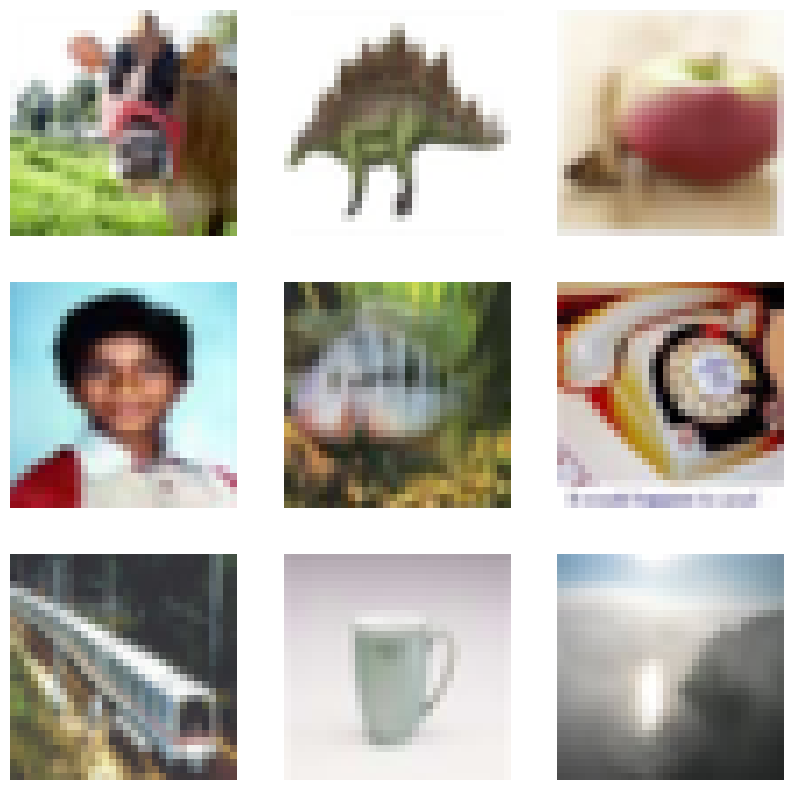

In [8]:
# Assuming you have loaded the data as x_train
# Let's plot the first 9 images from the training set
fig, axes = plt.subplots(3, 3, figsize=(10, 10))
for i, ax in enumerate(axes.flat):
    ax.imshow(x_train[i])
    ax.axis('off')
plt.show()

**Check for class distribution**

Each bar has a uniform height, indicating that each class within the CIFAR-100 dataset has an equal number of samples—specifically, 500 samples per class and class labels ranging from 0 to 99, indicating 100 distinct classes.


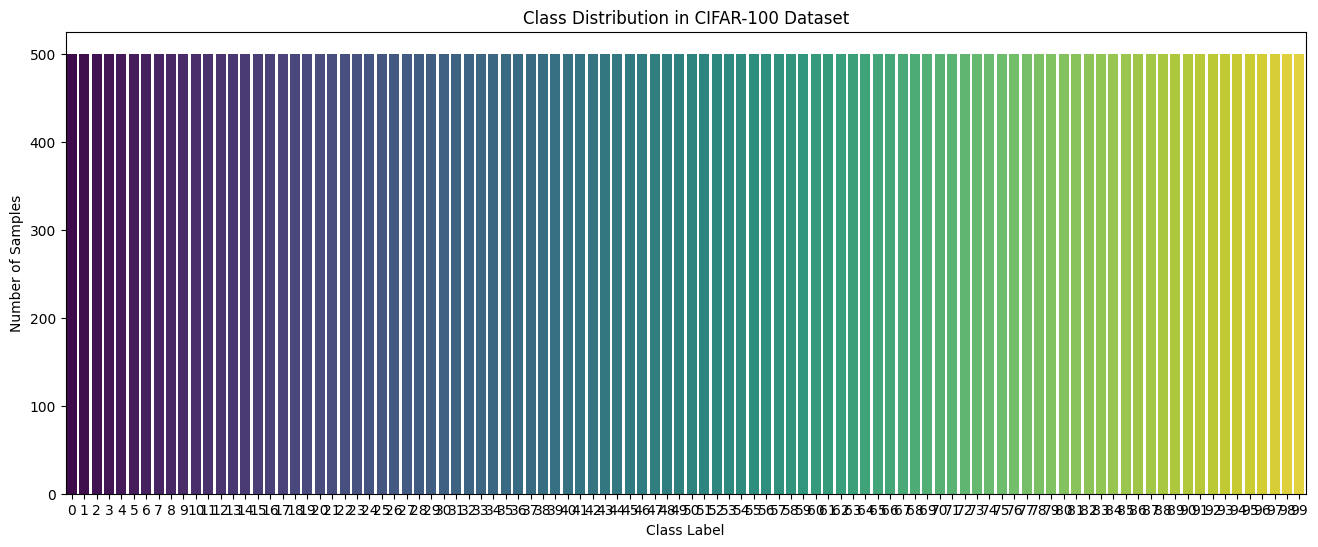

In [12]:
# Flatten the labels array for easier counting
y_train = y_train.flatten()

# Count occurrences of each class
unique, counts = np.unique(y_train, return_counts=True)
class_counts = dict(zip(unique, counts))

# Plot class distribution
plt.figure(figsize=(16, 6))
sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()), hue=list(class_counts.keys()), palette="viridis", legend=False)
plt.xlabel("Class Label")
plt.ylabel("Number of Samples")
plt.title("Class Distribution in CIFAR-100 Dataset")
plt.show()